#Try Stock Prediction - BBCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import joblib
import yfinance as yf
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## 1. Read Data

In [ ]:
# stock_data = pd.read_csv('/content/NFLX.csv', index_col='Date')
# stock_data

ticker = 'BBCA.JK'
# start_date = '2020-05-20'
# end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = '2020-05-21'
end_date = '2024-05-21'
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-26,4775.0,5000.0,4775.0,4970.0,4557.095703,176076500
2020-05-27,4970.0,5000.0,4855.0,4965.0,4552.511230,151753500
2020-05-28,5000.0,5320.0,5000.0,5295.0,4855.094727,229233000
2020-05-29,5295.0,5295.0,5190.0,5190.0,4758.818359,399414000
2020-06-02,5260.0,5500.0,5240.0,5360.0,4914.694824,181369500
...,...,...,...,...,...,...
2024-05-14,9625.0,9675.0,9525.0,9550.0,9550.000000,95363500
2024-05-15,9500.0,9600.0,9425.0,9500.0,9500.000000,54741900
2024-05-16,9575.0,9675.0,9525.0,9600.0,9600.000000,61126000


## 2. Plotting Data

### 2.1 Plot High & Low

In [ ]:
# Define function to create input and output sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Hyperparameters
seq_length = 7
n_features = stock_data.shape[1]
n_units = 64
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 32
epochs = 50

### 2.2 Plot Open & Close

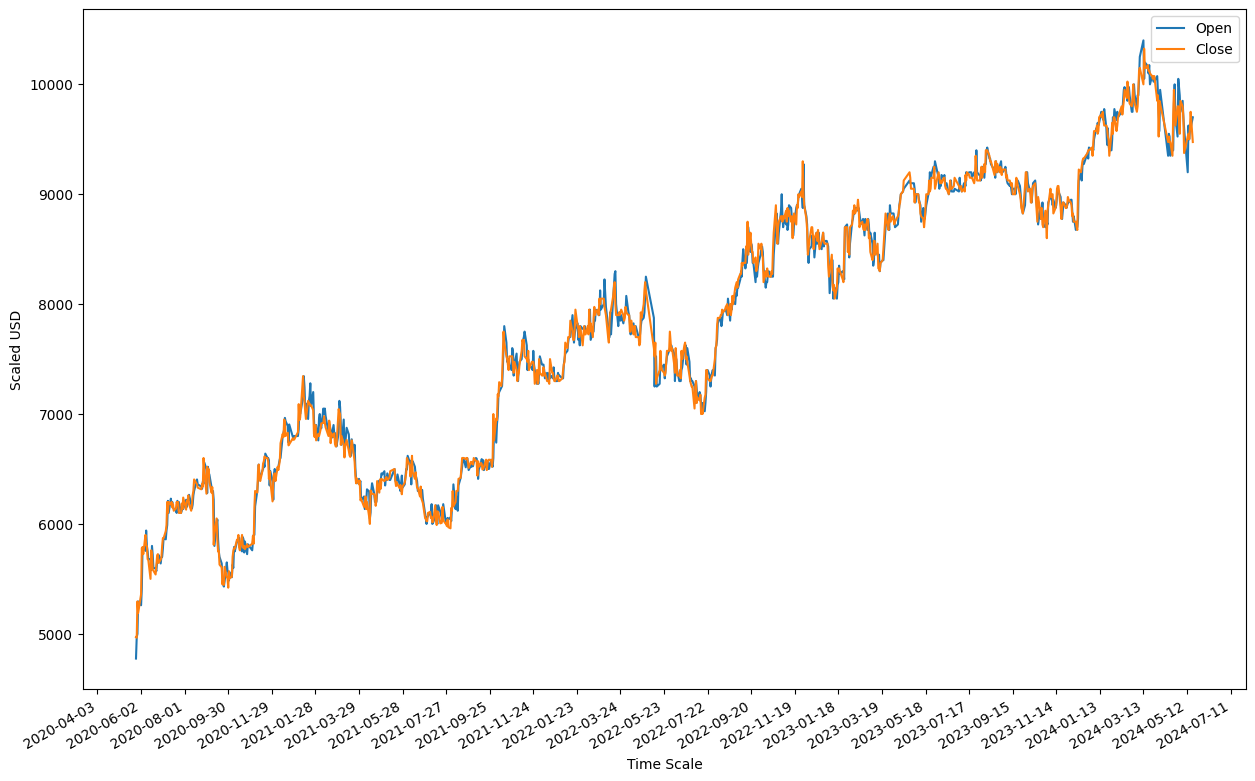

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
# x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
x_dates = stock_data.index

plt.plot(x_dates, stock_data['Open'], label='Open')
plt.plot(x_dates, stock_data['Close'], label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## 3. Stock Prediction

### 3.1 Normalize or Rescale

In [ ]:
features = stock_data.iloc[:, 0:4]
sc = StandardScaler()
features_scaled = sc.fit_transform(features.values)
stock_data_ft = pd.DataFrame(columns=features.columns, data=features_scaled, index=features.index)

# Simpan objek StandardScaler
joblib.dump(sc, 'standard_scaler.pkl')


['standard_scaler.pkl']

### 3.2 Train & Test

#### 3.2.1 Splitting

In [ ]:
def lstm_split(data, n_steps):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [ ]:
n_steps = 6
X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[n_steps-1:split_idx + n_steps-1], date_index[split_idx + n_steps-1:len(X1) + n_steps-1]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(957, 6, 3) (766, 6, 3) (191, 6, 3) (191,)


#### 3.2.2 Training

In [ ]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
lstm.add(Dropout(0.4))
lstm.add(LSTM(50, activation='tanh'))
lstm.add(Dropout(0.2))
lstm.add(Dense(100, activation = 'relu'))
lstm.add(Dense(100, activation = 'relu'))
lstm.add(Dense(1, activation = 'linear'))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 6, 50)             10800     
                                                                 
 dropout_14 (Dropout)        (None, 6, 50)             0         
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 100)               5100      
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 1)                

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=2, verbose = 1, shuffle=True, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
306/306 [==============================] - 9s 16ms/step - loss: 0.0661 - val_loss: 0.0365
Epoch 2/100
306/306 [==============================] - 4s 12ms/step - loss: 0.0284 - val_loss: 0.0289
Epoch 3/100
306/306 [==============================] - 3s 9ms/step - loss: 0.0294 - val_loss: 0.0142
Epoch 4/100
306/306 [==============================] - 2s 8ms/step - loss: 0.0243 - val_loss: 0.0089
Epoch 5/100
306/306 [==============================] - 2s 7ms/step - loss: 0.0193 - val_loss: 0.0095
Epoch 6/100
306/306 [==============================] - 2s 8ms/step - loss: 0.0190 - val_loss: 0.0474
Epoch 7/100
306/306 [==============================] - 3s 11ms/step - loss: 0.0187 - val_loss: 0.0111
Epoch 8/100
306/306 [==============================] - 3s 8ms/step - loss: 0.0167 - val_loss: 0.0439
Epoch 9/100
306/306 [==============================] - 3s 9ms/step - loss: 0.0160 - val_loss: 0.0066
Epoch 10/100
306/306 [==============================] - 3s 9ms/step - loss: 0.0148 - val

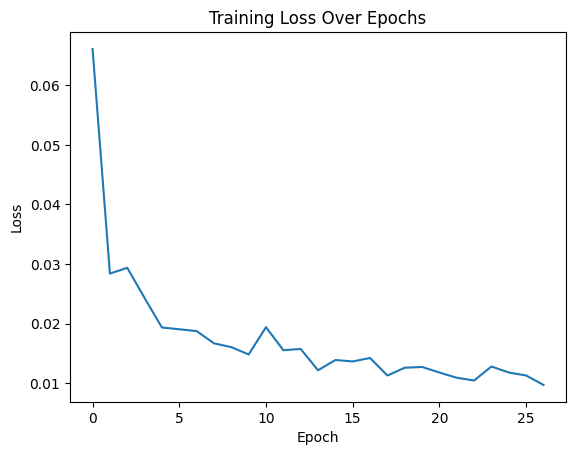

In [ ]:
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 3.2.3 Evaluation

6/6 [==============================] - 1s 5ms/step


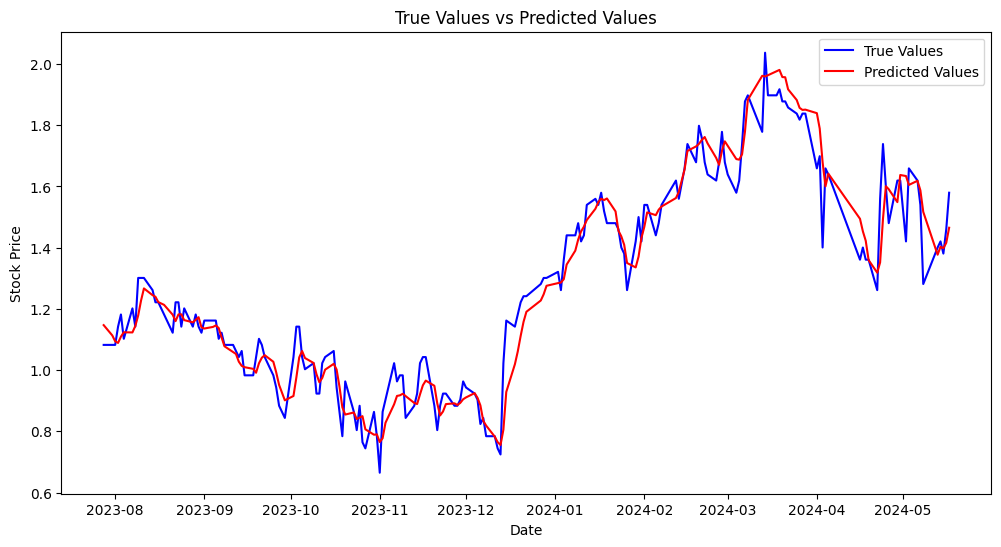

In [ ]:
# Make predictions
y_pred = lstm.predict(X_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_test_date, y_test, label='True Values', color='blue')
plt.plot(X_test_date, y_pred, label='Predicted Values', color='red')
plt.title('True Values vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.075957842727428
MAPE:  0.046906681375991265


In [ ]:
# Save Model
lstm.save("predict_bbca.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.2.4 Compare Performance

In [ ]:
n_steps_list = [2, 6, 13, 20]
results = []
models = []

for n_steps in n_steps_list:
    X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

    split_idx = int(np.ceil(len(X1) * 0.8))
    X_train, X_test = X1[:split_idx], X1[split_idx:]
    y_train, y_test = y1[:split_idx], y1[split_idx:]

    lstm = Sequential()
    lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(50, activation='tanh'))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    lstm.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

    y_pred = lstm.predict(X_test)
    y_pred = y_pred.flatten()  # Ensure y_pred is a 1D array

    #sc_y.fit(y_train.reshape(-1, 1))  # Fit scaler on training target data
    #y_pred = sc_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    #y_test = sc_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append((n_steps, rmse, mape))
    models.append(lstm)

Epoch 1/100
193/193 - 5s - loss: 0.2012 - 5s/epoch - 24ms/step
Epoch 2/100
193/193 - 1s - loss: 0.0186 - 778ms/epoch - 4ms/step
Epoch 3/100
193/193 - 1s - loss: 0.0168 - 854ms/epoch - 4ms/step
Epoch 4/100
193/193 - 1s - loss: 0.0175 - 1s/epoch - 6ms/step
Epoch 5/100
193/193 - 1s - loss: 0.0190 - 1s/epoch - 7ms/step
Epoch 6/100
193/193 - 1s - loss: 0.0197 - 1s/epoch - 7ms/step
Epoch 7/100
193/193 - 1s - loss: 0.0152 - 1s/epoch - 8ms/step
Epoch 8/100
193/193 - 1s - loss: 0.0140 - 1s/epoch - 6ms/step
Epoch 9/100
193/193 - 1s - loss: 0.0180 - 1s/epoch - 6ms/step
Epoch 10/100
193/193 - 1s - loss: 0.0133 - 1s/epoch - 6ms/step
Epoch 11/100
193/193 - 1s - loss: 0.0145 - 806ms/epoch - 4ms/step
Epoch 12/100
193/193 - 1s - loss: 0.0189 - 817ms/epoch - 4ms/step
Epoch 13/100
193/193 - 1s - loss: 0.0171 - 866ms/epoch - 4ms/step
Epoch 14/100
193/193 - 1s - loss: 0.0143 - 1s/epoch - 5ms/step
Epoch 15/100
193/193 - 1s - loss: 0.0150 - 1s/epoch - 5ms/step
Epoch 16/100
193/193 - 1s - loss: 0.0172 - 1s/ep

KeyboardInterrupt: 

In [ ]:
for result in results:
    print(f"n_steps: {result[0]}, RMSE: {result[1]}, MAPE: {result[2]}")

n_steps: 2, RMSE: 0.054223322950845886, MAPE: 0.033374105340811845
n_steps: 6, RMSE: 0.12015218196890087, MAPE: 0.06456733087487916
n_steps: 13, RMSE: 0.08829705833721276, MAPE: 0.04980698892466875
n_steps: 20, RMSE: 0.14115275468155905, MAPE: 0.08046369666076525


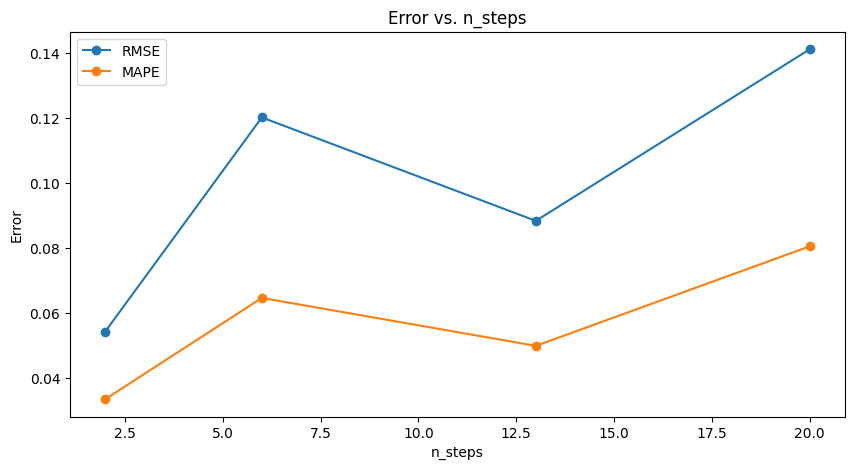

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot([result[0] for result in results], [result[1] for result in results], marker='o', label='RMSE')
plt.plot([result[0] for result in results], [result[2] for result in results], marker='o', label='MAPE')
plt.xlabel('n_steps')
plt.ylabel('Error')
plt.title('Error vs. n_steps')
plt.legend()
plt.show()

The result shows that n_steps = n will reach the most accurate prediction, means that predicting the n+1th days is the best choice

#### 3.2.5 Cross Validation

In [ ]:
# n_steps = 6
# X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5)
# rmse_scores = []
# mape_scores = []

# for train_index, test_index in tscv.split(X1):
#     X_train, X_test = X1[train_index], X1[test_index]
#     y_train, y_test = y1[train_index], y1[test_index]

#     # Define the model
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
#     model.add(LSTM(50, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     # Train the model
#     model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, shuffle=False)

#     # Predict
#     y_pred = model.predict(X_test)
#     y_pred = y_pred[:, 0]

#     # Calculate RMSE and MAPE
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     mape = mean_absolute_percentage_error(y_test, y_pred)

#     rmse_scores.append(rmse)
#     mape_scores.append(mape)

# print(f"Average RMSE: {np.mean(rmse_scores)}, Average MAPE: {np.mean(mape_scores)}")

###3.3 Run Saved Model

In [ ]:
# Load the SavedModel
model = tf.keras.models.load_model('predict_bbca.h5')
sc = joblib.load('standard_scaler.pkl')

In [ ]:
def prepare_input_data(ticker, end_date, n_steps):
    stock_data = yf.download(ticker, end=end_date)
    X_feat = stock_data[['Open', 'High', 'Low']]
    target_y = stock_data['Close']

    X_ft = sc.fit_transform(X_feat.values)
    stock_data_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)
    stock_data_ft['Close'] = target_y.values

    input_data = stock_data_ft.values[-n_steps:, :-1]
    input_data = np.expand_dims(input_data, axis=0)

    return input_data, stock_data_ft.index[-1]

In [ ]:
# Parameter prediksi
ticker = 'BBCA.JK'
end_date = '2024-05-15'
n_steps = 6

# Menyiapkan data input
input_data, last_date = prepare_input_data(ticker, end_date, n_steps)

# Melakukan prediksi
predicted_price_scaled = model.predict(input_data).flatten()[0]

# Mengembalikan hasil prediksi ke skala semula
predicted_price = sc.inverse_transform([[np.nan, predicted_price_scaled, np.nan]])[0][1]

# Menampilkan hasil prediksi
print(f"Harga saham {ticker} yang diprediksi untuk tanggal {end_date} adalah: {predicted_price:.2f}")

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 3s 3s/step
Harga saham BBCA.JK yang diprediksi untuk tanggal 2024-05-15 adalah: 9436.35
